In [1]:
import wikiqahelper
import wordrepresentation
import data_stats
from wikiqahelper import load_questions_from_file
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import tokenize
import numpy as np
from keras.engine import Input
from keras.layers import LSTM, SimpleRNN, GRU, Dense, Dropout, Activation, Embedding, Input, merge
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from gensim.models import Doc2Vec
from gensim.models import Word2Vec
from nltk.corpus import wordnet as wn
import matplotlib.pyplot as plt
import numpy as np
import sys
import logging
from scipy import spatial
%matplotlib inline

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5103)
Using Theano backend.


In [2]:
#name used to generate treceval file and checkpoint
filename = 'Keras-LSTM-w2v_wnet_features.rank'
weights  = 'weights-best-kmf.hdf5'

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [3]:
def load_w2v():
    _fname = "GoogleNews-vectors-negative300.bin"
    w2vModel = Doc2Vec.load_word2vec_format(_fname, binary=True)
    return w2vModel 

In [4]:
w2v = load_w2v()

In [5]:
def word2vectSimilarity(list1, list2, w2v_model):
    sum_list1 = np.zeros(300)
    sum_list2 = np.zeros(300)
    mult_vector = np.ones(300)
    for wq in list1:
        try:
            sum_list1 += w2v_model[wq]
        except Exception as e:
            logger.debug("Word not in word2vect vocabulary "+wq)
    for aq in list2: 
        try:
            sum_list2 += w2v_model[aq]
        except Exception as e:
            logger.debug("Word not in word2vect vocabulary "+aq)
    #print len(sum_list1), len(sum_list2)
    #result = spatial.distance.cosine(sum_list1, sum_list2)
    #result = np.multiply(sum_list1, sum_list2)
    #result = np.concatenate((sum_list1, sum_list2, np.multiply(sum_list1, sum_list2)))
    result = np.concatenate((sum_list1, sum_list2))
    return result

In [6]:
#print word2vectSimilarity(['sky','dog','window', 'material'],['the','car','is', 'red'],w2v)

In [7]:
def buildQAPairs(dataset):
    #Construct Question Answer Pairs
    questions_answer_pairs = []

    for k, test_q_k in enumerate(dataset):
        q = test_q_k.question
        for i, a_i in enumerate(test_q_k.answers):
            is_correct = 1 if i in test_q_k.correct_answer else 0
            questions_answer_pairs += [(q, a_i, is_correct)]
    return questions_answer_pairs

In [8]:
def prepoSentence(s):
    terms = tokenize(s)
    terms = [word for word in terms ]#if word not in STOPWORDS]
    return terms
    
def getWord2Vect(qaPair, MAX_WORDS=50):
    question = prepoSentence(qaPair[0])
    answer = prepoSentence(qaPair[1])
    q_vect = []
    a_vect = []
    for i in range(MAX_WORDS):
        q_vect.append(w2v[question[i]] if len(question)>i and question[i] in w2v else np.zeros(300))
        a_vect.append(w2v[answer[i]] if len(answer)>i and answer[i] in w2v else np.zeros(300))
    #label = [1,0] if qaPair[2] == 1 else [0,1]
    label = qaPair[2]
    return q_vect, a_vect, label

In [9]:
#Construct Training dataset 
questions = {}
questions['train'], vocabulary, idf = load_questions_from_file('train', -1)
questions['validate'], vocabulary, idf = load_questions_from_file('validate', -1)
questions['test'], vocabulary, idf = load_questions_from_file('test', -1)
#Get train qa pairs
train_questions_answer_pairs = buildQAPairs(questions['train'])
test_questions_answer_pairs = buildQAPairs(questions['test'])
validate_questions_answer_pairs = buildQAPairs(questions['validate'])

In [15]:
print sum([1 for qa in validate_questions_answer_pairs if qa[2]==1])

140


In [16]:
print sum([1 for qa in validate_questions_answer_pairs if qa[2]==0])

2576


In [14]:
len(questions['train'])

2117

In [39]:
train_questions_answer_pairs[0]

(u'how are glacier caves formed ?',
 u'A partly submerged glacier cave on Perito Moreno Glacier .',
 0)

In [40]:
'''
for i, p in enumerate(train_questions_answer_pairs):
    #p = train_questions_answer_pairs[500]
    r = word2vectSimilarity(prepoSentence(p[0]),prepoSentence(p[1]),w2v)
    print i, ' ---> ',r,p[2]
'''
#train_questions_answer_pairs[1033]
#print word2vectSimilarity(prepoSentence(pair[0]),prepoSentence(pair[0]),w2v)
#print word2vectSimilarity(['bicycle'],['bike'],w2v)
#pair
#print set(prepoSentence(pair[0])) | set(prepoSentence(pair[1])) 
#len(set(list1) | set(list2))< (len(set(list1))+len(set(list2))):
#print word2vectSimilarity(prepoSentence(p[0]),prepoSentence(p[1]),w2v)

"\nfor i, p in enumerate(train_questions_answer_pairs):\n    #p = train_questions_answer_pairs[500]\n    r = word2vectSimilarity(prepoSentence(p[0]),prepoSentence(p[1]),w2v)\n    print i, ' ---> ',r,p[2]\n"

In [41]:
#load w2vect - wnet features
train_questions_answer_pairs = [ (list(pair),word2vectSimilarity(prepoSentence(pair[0]),prepoSentence(pair[1]),w2v)) \
                            for i, pair in enumerate(train_questions_answer_pairs) ]
test_questions_answer_pairs = [ (list(pair),word2vectSimilarity(prepoSentence(pair[0]),prepoSentence(pair[1]),w2v)) \
                            for i, pair in enumerate(test_questions_answer_pairs) ]
validate_questions_answer_pairs = [ (list(pair),word2vectSimilarity(prepoSentence(pair[0]),prepoSentence(pair[1]),w2v)) \
                            for i, pair in enumerate(validate_questions_answer_pairs) ]

In [42]:
#train_questions_answer_pairs[0]

In [43]:
q_bins = [ len(prepoSentence(t_qa[0][0])) for t_qa in train_questions_answer_pairs ]
a_bins = [ len(prepoSentence(t_qa[0][1])) for t_qa in train_questions_answer_pairs ]

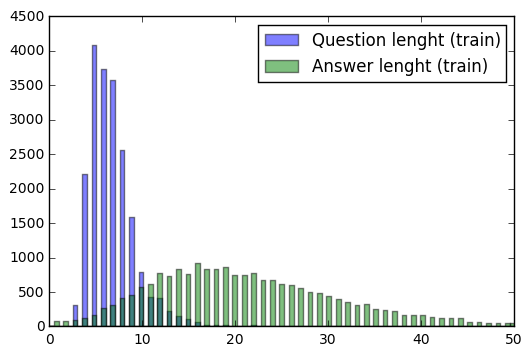

In [44]:
bins = np.linspace(0, 50, 100)
plt.hist(q_bins, bins, alpha=0.5, label='Question lenght (train)')
plt.hist(a_bins, bins, alpha=0.5, label='Answer lenght (train)')
plt.legend()
plt.show()

In [45]:
def generateXYBatches(validation=False, samples=2200, MAX_WORDS=50):
    half_samples = samples/2
    positiveSamples = [ q for q in train_questions_answer_pairs if q[0][2]==1 ]
    negativeSamples = [ q for q in train_questions_answer_pairs if q[0][2]==0 ]
    if validation:
        positiveSamples = [ q for q in validate_questions_answer_pairs if q[0][2]==1 ]
        negativeSamples = [ q for q in validate_questions_answer_pairs if q[0][2]==0 ]
    while 1:
        train_X1 = []
        train_X2 = []
        train_X3 = []
        train_Y = []
        rand_vector_pos = np.random.randint(0,len(positiveSamples),size=half_samples)
        rand_vector_neg = np.random.randint(0,len(negativeSamples),size=half_samples)
        X_pos = [ positiveSamples[i] for i in range(len(positiveSamples)) if i in rand_vector_pos]
        X_neg = [ negativeSamples[i] for i in range(len(negativeSamples)) if i in rand_vector_neg]
        for qa_pair in X_pos:
            q_vect, a_vect, label = getWord2Vect(qa_pair[0], MAX_WORDS)
            train_X1.append(q_vect)
            train_X2.append(a_vect)
            train_X3.append(qa_pair[1])
            train_Y.append(label)
        for qa_pair in X_neg:
            q_vect, a_vect, label = getWord2Vect(qa_pair[0], MAX_WORDS)
            train_X1.append(q_vect)
            train_X2.append(a_vect)
            train_X3.append(qa_pair[1])
            train_Y.append(label)
        train_X1 = np.array(train_X1)
        train_X2 = np.array(train_X2)
        train_X3 = np.array(train_X3)
        #train_X  = np.sum([train_X1,train_X2],axis=0)
        train_Y = np.array(train_Y)
        #X = X_pos + X_neg
        #train_q, train_a, train_l = wikiqa_model.buildWord2VectMatrix(X)
        #q_vect, a_vect, label = getWord2Vect(qa_pair)
        print "   Samples generated = ", len(train_X1), '  -  Validation(',validation, ')'
        #yield (train_X, train_Y)
        yield ([train_X1, train_X2, train_X3], train_Y)

In [61]:
timesteps = 50
question_input = Input(shape=(timesteps, 300))
answer_input = Input(shape=(timesteps, 300))
w2v_cos_distance = Input(shape=(600,))
shared_lstm = LSTM(64)
encoded_q = shared_lstm(question_input)
encoded_a = shared_lstm(answer_input)
merged_vector = merge([encoded_q, encoded_a], mode='concat', concat_axis=-1)
sim = Dense(32, activation='sigmoid')(merged_vector)
sim_w2v = Dense(32, activation='sigmoid')(w2v_cos_distance)
merged_vector_2 = merge([sim, sim_w2v], mode='concat', concat_axis=-1)
sim2 = Dense(64, activation='sigmoid')(merged_vector_2)
drop = Dropout(0.2)(sim2)
sim3 = Dense(32, activation='sigmoid')(drop)
predictions = Dense(1, activation='sigmoid')(sim3)

# If it is necessary to load the best pretrained weights
# model.load_weights("check-points/"+filename+"-weights-best.hdf5")

model = Model(input=[question_input, answer_input,w2v_cos_distance], output=predictions)

model.compile(optimizer='rmsprop',
              loss="binary_crossentropy",# kullback_leibler_divergence mean_squared_error
              metrics=['accuracy'])

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_16 (InputLayer)            (None, 50, 300)       0                                            
____________________________________________________________________________________________________
input_17 (InputLayer)            (None, 50, 300)       0                                            
____________________________________________________________________________________________________
lstm_6 (LSTM)                    (None, 64)            93440       input_16[0][0]                   
                                                                   input_17[0][0]                   
____________________________________________________________________________________________________
merge_11 (Merge)                 (None, 128)           0           lstm_6[0][0]            

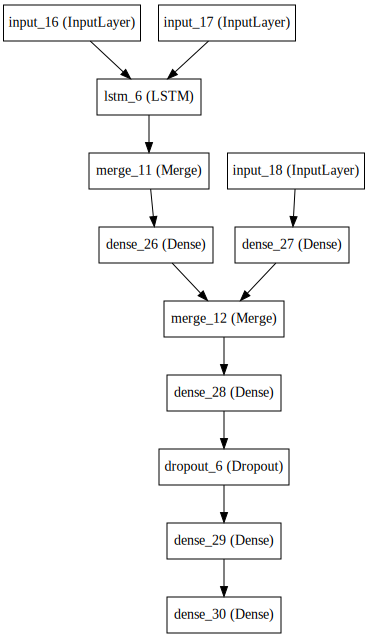

In [62]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [65]:
# checkpoints
filepath="check-points/"+filename+"-"+weights
#output the model weights each time an improvement is observed during training
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#stops if the model is not learning at any point
earlyStopping=EarlyStopping(monitor='accuracy', patience=50, verbose=1, mode='auto')

In [66]:
epochs_number = 500
history = model.fit_generator(generateXYBatches(validation=False, MAX_WORDS=timesteps), samples_per_epoch=2000, \
            validation_data=generateXYBatches(validation=True,samples=500, MAX_WORDS=timesteps), nb_val_samples=400, \
            nb_epoch=epochs_number, callbacks=[checkpoint, earlyStopping])

Epoch 1/500
   Samples generated =  1736   -  Validation( False )
   Samples generated =  1733   -  Validation( False )
1736/2000 [=========================>....] - ETA: 0s - loss: 0.3358 - acc: 0.8727   Samples generated =  1748   -  Validation( False )
   Samples generated =  1746   -  Validation( False )
   Samples generated =  358   -  Validation( True )
   Samples generated =  357   -  Validation( True )
Epoch 00000: val_acc improved from -inf to 0.70350, saving model to check-points/Keras-LSTM-w2v_wnet_features.rank-weights-best-kmf.hdf5
3469/2000 [====================================================] - 4s - loss: 0.3241 - acc: 0.8732 - val_loss: 0.7076 - val_acc: 0.7035
Epoch 2/500
   Samples generated =  361   -  Validation( True )


/home/aerossom/.conda/envs/py2/lib/python2.7/site-packages/keras/callbacks.py:358: RuntimeWarning: Early stopping requires accuracy available!
  (self.monitor), RuntimeWarning)


   Samples generated =  1740   -  Validation( False )
   Samples generated =  1732   -  Validation( False )
1748/2000 [=========================>....] - ETA: 0s - loss: 0.3968 - acc: 0.8284   Samples generated =  1729   -  Validation( False )
   Samples generated =  356   -  Validation( True )
   Samples generated =  359   -  Validation( True )
   Samples generated =  1740   -  Validation( False )
   Samples generated =  357   -  Validation( True )
Epoch 00001: val_acc did not improve
3494/2000 [====================================================] - 3s - loss: 0.3781 - acc: 0.8363 - val_loss: 0.6888 - val_acc: 0.6965
Epoch 3/500
   Samples generated =  360   -  Validation( True )
   Samples generated =  1751   -  Validation( False )
1740/2000 [=========================>....] - ETA: 0s - loss: 0.3610 - acc: 0.8546   Samples generated =  1745   -  Validation( False )
   Samples generated =  1755   -  Validation( False )
   Samples generated =  355   -  Validation( True )
   Samples gene

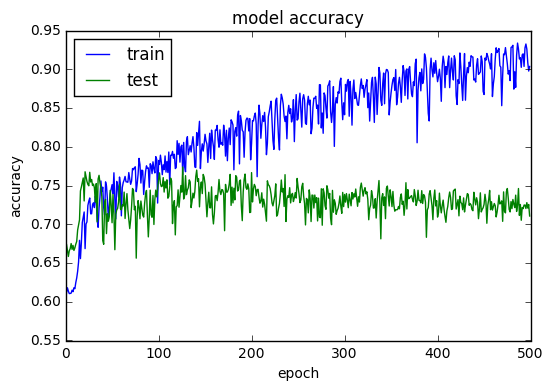

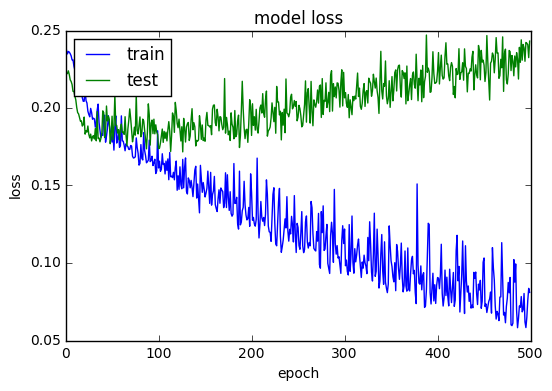

In [51]:
# Print learning history
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [52]:
#reload best weights
model.load_weights("check-points/"+filename+"-"+weights)
print "check-points/"+filename+"-weights-best.hdf5"

check-points/Keras-LSTM-w2v_wnet_features.rank-weights-best.hdf5


In [53]:
#Construct Test dataset 
test_X1 = []
test_X2 = []
test_X3 = []
test_Y = []           

for qa_pair in test_questions_answer_pairs:
    q_vect, a_vect, label = getWord2Vect(qa_pair[0],MAX_WORDS=timesteps)
    test_X1.append(q_vect)
    test_X2.append(a_vect)
    test_X3.append(qa_pair[1])
    test_Y.append(label)
    
test_X1 = np.array(test_X1)
test_X2 = np.array(test_X2)
test_X3 = np.array(test_X3)
test_Y = np.array(test_Y)

print test_X1.shape, test_Y.shape

(6156, 50, 300) (6156,)


In [54]:
loss, acc = model.evaluate([test_X1, test_X2, test_X3], test_Y, 50)
#loss, acc = model.evaluate(test_X, test_Y, batch_size, show_accuracy=True)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss, acc))

6156/6156 [==============================] - 4s     
Test loss / test accuracy = 0.1530 / 0.8093


In [55]:
predictions = model.predict([test_X1, test_X2, test_X3])

In [56]:
print np.sum(predictions, axis=0), predictions[1234], np.sum(test_Y, axis=0)

[ 1473.4375] [ 0.24401106] 293


In [57]:
print np.sum(predictions, axis=0), predictions[22], np.sum(test_Y, axis=0)

[ 1473.4375] [ 0.0528559] 293


In [58]:
def genTrecEvalFile(result, filename):
    idx_pred = 0
    with open('experiments/'+filename, 'wb') as text_file:
        for i, test_q_i in enumerate(questions['test']):
            for j, a_j in enumerate(test_q_i.answers):
                # 1 --> [1,0]
                #label = 1 if (predictions[idx_pred][0]-0.06)>predictions[idx_pred][1] else 0
                label = predictions[idx_pred][0]
                str_out = str(i + 1) + ' 0 ' + str(j) + ' 0 ' + str(label) + ' 0\n'
                idx_pred += 1
                text_file.write(str_out)

In [59]:
genTrecEvalFile(predictions, filename)
print filename

Keras-LSTM-w2v_wnet_features.rank


In [60]:
!/home/aerossom/trec_eval.9.0/trec_eval -c ../datasets/WikiQACorpus/WikiQA-test-filtered.ref experiments/Keras-LSTM-w2v_wnet_features.rank

runid                 	all	0
num_q                 	all	237
num_ret               	all	2341
num_rel               	all	283
num_rel_ret           	all	283
map                   	all	0.5302
gm_map                	all	0.4121
Rprec                 	all	0.3277
bpref                 	all	0.3267
recip_rank            	all	0.5482
iprec_at_recall_0.00  	all	0.5519
iprec_at_recall_0.10  	all	0.5519
iprec_at_recall_0.20  	all	0.5519
iprec_at_recall_0.30  	all	0.5455
iprec_at_recall_0.40  	all	0.5379
iprec_at_recall_0.50  	all	0.5379
iprec_at_recall_0.60  	all	0.5196
iprec_at_recall_0.70  	all	0.5196
iprec_at_recall_0.80  	all	0.5195
iprec_at_recall_0.90  	all	0.5195
iprec_at_recall_1.00  	all	0.5195
P_5                   	all	0.1899
P_10                  	all	0.1135
P_15                  	all	0.0779
P_20                  	all	0.0595
P_30                  	all	0.0398
P_100                 	all	0.0119
P_200                 	all	0.0060
P_500                 	all	0.0024
P_1000                	all	0.0

In [31]:
#!cat ../passage-retrieval/experiments/lstm-sum.rank 

In [3]:
!/home/aerossom/trec_eval-9.0/trec_eval -c ../passage-retrieval/experiments/gold-jakana-test.rank ../passage-retrieval/experiments/keras_lstm_1489277643.rank

/bin/sh: 1: /home/aerossom/trec_eval-9.0/trec_eval: not found
